In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/samokattechworkshop/base.csv
/kaggle/input/samokattechworkshop/train.csv
/kaggle/input/samokattechworkshop/test.csv
/kaggle/input/samokattechworkshop/baseline.ipynb
/kaggle/input/samokattechworkshop/answer_sample.csv


In [2]:
pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 40.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


Подключаем необходмые библиотеки.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import faiss

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Загружаем данные.

In [4]:
base = pd.read_csv('/kaggle/input/samokattechworkshop/base.csv')
train = pd.read_csv('/kaggle/input/samokattechworkshop/train.csv')
test = pd.read_csv('/kaggle/input/samokattechworkshop/test.csv')
answer_sample = pd.read_csv('/kaggle/input/samokattechworkshop/answer_sample.csv')

Посмотрим, какие данные лежат в трейне, тесте и базе. И в каком формате.

In [5]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 74 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float64
 21  20      100

,Id,0,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,Target
0,0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1,1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2,2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3,3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4,4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [6]:
print(base.info())
base.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2918139 entries, 0 to 2918138
Data columns (total 73 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Id      object 
 1   0       float64
 2   1       float64
 3   2       float64
 4   3       float64
 5   4       float64
 6   5       float64
 7   6       float64
 8   7       float64
 9   8       float64
 10  9       float64
 11  10      float64
 12  11      float64
 13  12      float64
 14  13      float64
 15  14      float64
 16  15      float64
 17  16      float64
 18  17      float64
 19  18      float64
 20  19      float64
 21  20      float64
 22  21      float64
 23  22      float64
 24  23      float64
 25  24      float64
 26  25      float64
 27  26      float64
 28  27      float64
 29  28      float64
 30  29      float64
 31  30      float64
 32  31      float64
 33  32      float64
 34  33      float64
 35  34      float64
 36  35      float64
 37  36      float64
 38  37      float64
 39  38      float64
 40  

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1,1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2,2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3,3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4,4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [7]:
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float64
 21  20      100

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
1,100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
2,100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
3,100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
4,100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


Во вех стобцах, кроме ID находятся числа. Посмотрим, в каком диапазоне лежат их значения.

In [8]:
base.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,...,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.622947e+01,8.080077e+00,-4.458080e+01,-1.466350e+02,1.113166e+02,-7.199138e+01,-3.922239e+02,2.035283e+01,1.236842e+02,1.244581e+02,...,-7.902286e+01,3.329735e+01,-1.547962e+02,1.415132e+01,6.779167e+01,2.354490e+01,7.495930e+01,1.155667e+02,-7.993390e+02,-4.779125e+01
std,2.489132e+01,4.953387e+00,3.863166e+01,1.984480e+01,4.634809e+01,2.818607e+01,2.716550e+02,6.421638e+01,6.356109e+00,6.443058e+01,...,3.045642e+01,2.888603e+01,4.122929e+01,9.895115e+01,1.823356e+00,5.534224e+01,6.134500e+01,2.117518e+01,3.854131e+02,4.174802e+01
min,-1.994687e+02,-1.391461e+01,-2.400734e+02,-2.326671e+02,-1.055830e+02,-2.110086e+02,-7.914699e+02,-3.018597e+02,9.315305e+01,-1.738719e+02,...,-2.205662e+02,-8.850774e+01,-3.539028e+02,-1.575944e+02,5.950944e+01,-2.331382e+02,-2.036016e+02,1.572448e+01,-1.297931e+03,-2.267801e+02
25%,-1.030654e+02,4.708491e+00,-6.955949e+01,-1.599051e+02,8.050795e+01,-9.137994e+01,-6.293318e+02,-2.222147e+01,1.194840e+02,8.176751e+01,...,-9.876390e+01,1.698862e+01,-1.807799e+02,-7.130038e+01,6.658096e+01,-1.251624e+01,3.377574e+01,1.016867e+02,-1.074465e+03,-7.566641e+01
50%,-8.623150e+01,8.038950e+00,-4.381661e+01,-1.467768e+02,1.118730e+02,-7.192230e+01,-4.222016e+02,2.080477e+01,1.238923e+02,1.234977e+02,...,-7.848812e+01,3.471502e+01,-1.539773e+02,1.382693e+01,6.781458e+01,2.341649e+01,7.492997e+01,1.160244e+02,-1.074465e+03,-4.859196e+01
75%,-6.925658e+01,1.147007e+01,-1.962527e+01,-1.333277e+02,1.423743e+02,-5.244111e+01,-1.566686e+02,6.391821e+01,1.279705e+02,1.672206e+02,...,-5.853355e+01,5.216429e+01,-1.273405e+02,9.966753e+01,6.902666e+01,5.975511e+01,1.158760e+02,1.295524e+02,-5.057445e+02,-1.971424e+01
max,2.151555e+01,2.993721e+01,1.609372e+02,-5.137478e+01,3.196645e+02,5.880624e+01,1.096325e+02,3.412282e+02,1.522612e+02,4.275421e+02,...,6.017411e+01,1.541678e+02,2.436099e+01,1.850981e+02,7.571203e+01,3.148988e+02,3.395738e+02,2.147063e+02,9.877081e+01,1.269732e+02


Значения положительные и отрицательные. От нескольних десяткой в максимуме, до нескольких сотен. Нужно провести масштабирование. 

Переименуем DataFrame без ID.

In [9]:
t = train.drop(['Id','Target'], axis=1)
b = base.drop('Id', axis=1)
te = test.drop('Id', axis=1)

### *Пропуски в данных.*

Проверим файлы на пропуск
и.

In [10]:
train.isna().sum()

Id        0
0         0
1         0
2         0
3         0
         ..
68        0
69        0
70        0
71        0
Target    0
Length: 74, dtype: int64

In [11]:
base.isna().sum()

Id    0
0     0
1     0
2     0
3     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 73, dtype: int64

In [12]:
te.isna().sum()

0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64

*Вывод по пропускам:* Пропусков в данных нет. 

### Дубликаты.

Проверим данные на дубли.

In [13]:
train.duplicated().sum(), base.duplicated().sum(), te.duplicated().sum()

(0, 0, 0)

*Вывод по дубликатам:* Дубликатов в данных нет.

Посмотрим на длину эмбдингов.

In [14]:
b.shape[1], t.shape[1], te.shape[1] 

(72, 72, 72)

Длина эмбдингов 72 признака. 73 у теста потому, что мы его пока не "трогаем", там есть столбец с ID. 

In [15]:
base['Id'].nunique(), train['Id'].nunique(), test['Id'].nunique()

(2918139, 100000, 100000)

У нас по 100 тыс уникальных ID в трейне и тесте и 2,9 млн в базе. 

# IndexFlatIP + StandardScaler() + IndexIVFFlat + PCA 

Так как данные сильно разнятся от десятков до сотен применим StandardScaler.

In [16]:
scaler = StandardScaler()
t_scaled = scaler.fit_transform(t)
base_scaled = scaler.transform(b)
test_scaled = scaler.transform(te)

Признаковдостаточно много. Посмотрим на вклад признаков в дисперсию. Применим PCA.

In [17]:
pca = PCA(n_components=72)
pca.fit_transform(t_scaled)
prop_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_
prop_var

array([0.01967671, 0.01777149, 0.01702246, 0.01695116, 0.0167618 ,
       0.01651845, 0.01637426, 0.01614752, 0.01613288, 0.01600915,
       0.01595853, 0.01582678, 0.01572159, 0.01555417, 0.01547869,
       0.01545639, 0.01534601, 0.0151753 , 0.01510577, 0.01500672,
       0.01491434, 0.01484183, 0.01471251, 0.01469489, 0.01460143,
       0.01453655, 0.01445038, 0.01428526, 0.01425044, 0.01418354,
       0.01416966, 0.01410729, 0.01403355, 0.01395248, 0.01389273,
       0.01385843, 0.01377029, 0.01373496, 0.01367291, 0.01361983,
       0.01356716, 0.01348129, 0.0134349 , 0.01341152, 0.01331817,
       0.01324691, 0.01319375, 0.01312498, 0.012968  , 0.01290531,
       0.01283831, 0.01273947, 0.01267938, 0.01254235, 0.0124938 ,
       0.01247833, 0.01240033, 0.01226313, 0.01222001, 0.01203959,
       0.01195938, 0.0118831 , 0.01180706, 0.01172572, 0.01159039,
       0.01137183, 0.01126407, 0.01115307, 0.01098732, 0.01083799,
       0.01052757, 0.00926666])

Построим график доли объясненной дисперсии.

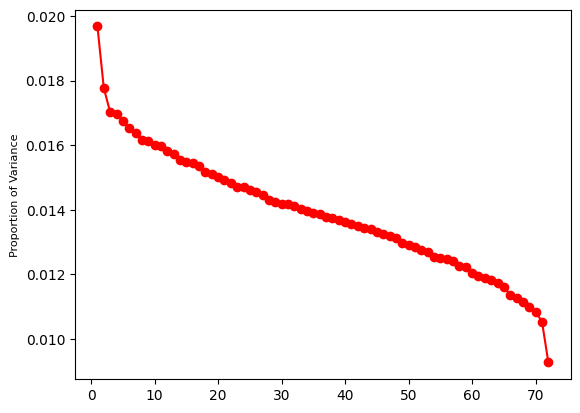

In [18]:
PC_numbers = np.arange(pca.n_components_) + 1
 
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.ylabel('Proportion of Variance', fontsize=8)
plt.show()

Лишь 1 признак вносит около 2%. Остальные около 1,5 а некоторые и менее. Попробуем остановится на тех, кто вноит вклад более 1,5 %. Остановимся на 65 признаках. Обучим PCE на трейне и применим к базе и тесту. 

In [19]:
pca = PCA(n_components=65) 
pca.fit(t_scaled) 

t_scaled_reduced = pca.transform(t_scaled)
base_scaled_reduced = pca.transform(base_scaled)
test_scaled_reduced =  pca.transform(test_scaled)

Полученные данные будем обрабатывать с помощью библиотеки FAISS. C размерностью 65(согласно изменению РСА). На выходе должны получить 10 кандидатов.  Я пробовала разное кол-во признаков в РСА, разное значение nlist. Лучший скор, полученные за время принятия сабмитов был плучен в таком варианте:

Посмотрим сначала на работу на трейне.

In [20]:
%%time
d = 65 
k = 10  

nlist = 1
k = 10
quantizer = faiss.IndexFlatIP(d)  
index = faiss.IndexIVFFlat(quantizer, d, nlist)
assert not index.is_trained
index.train(base_scaled_reduced)
assert index.is_trained
index.add(base_scaled_reduced)

D, I = index.search(t_scaled_reduced, k)
dann = [base['Id'].loc[x] for x in I]

CPU times: user 4h 9min 2s, sys: 9.23 s, total: 4h 9min 11s
Wall time: 1h 4min 25s


In [21]:
for i in range(len(I)):
    dann[i] = [base['Id'].loc[x] for x in I[i]]
train['Predicted'] = dann
print(train['Target'][0])
train['Predicted'][0]

675816-base


['675816-base',
 '877519-base',
 '361564-base',
 '13406-base',
 '2725256-base',
 '1196008-base',
 '1408780-base',
 '379697-base',
 '3543241-base',
 '494555-base']

In [22]:
print(train['Target'][3])
train['Predicted'][3]

1472602-base


['1472602-base',
 '1184684-base',
 '489064-base',
 '2103038-base',
 '3341659-base',
 '219722-base',
 '124044-base',
 '782829-base',
 '446431-base',
 '2683980-base']

In [23]:
print(train['Target'][10])
train['Predicted'][10]

1790410-base


['1790410-base',
 '2684201-base',
 '266030-base',
 '2428735-base',
 '3554046-base',
 '3006692-base',
 '474720-base',
 '258545-base',
 '1409906-base',
 '418450-base']

Перейдем на тест.

In [ ]:
%%time
d = 65  
k = 10  

nlist = 1
k = 10
quantizer = faiss.IndexFlatIP(d)  
index = faiss.IndexIVFFlat(quantizer, d, nlist)
assert not index.is_trained
index.train(base_scaled_reduced)
assert index.is_trained
index.add(base_scaled_reduced)

D, I = index.search(test_scaled_reduced, k)
dann = [base['Id'].loc[x] for x in I]

In [ ]:
for i in range(len(I)):
    dann[i] = [base['Id'].loc[x] for x in I[i]]
answer_sample['Predicted'] = dann
for i in range(len(answer_sample)):
    answer_sample['Predicted'].loc[i] = ' '.join(str(x) for x in answer_sample['Predicted'].loc[i])
answer_sample[['Id','Predicted']].to_csv("answer_IndexFlatIPscaledIndexIVFFlatPCA.csv", index=False)
answer_sample